In [120]:
!pip install ollama                                                 # Install ollama
import pandas as pd                                                 # Import pandas for data manipulation
from sklearn.metrics import precision_score, recall_score, f1_score # Import performance metrics from scikit-learn
import ollama                                                       # Import ollama
import numpy as np                                                  # Import numpy for array operations

In [121]:
# Read & clean the file

# Specify `header=None` because the first row is not a real header.
df = pd.read_csv("genreLyrics.csv", sep="\t", header=None)

# Drop the first row (it contains the original header), then reset row indices
df_clean = df.drop(index=0).reset_index(drop=True)

# Rename the columns to meaningful names: keep song ID, genre, and lyrics
df_clean.columns = ["id", "genre", "lyrics"]

# Clean up whitespace from all columns
df_clean["id"] = df_clean["id"].astype(str).str.strip()   # Convert ID to string and strip spaces
df_clean["genre"] = df_clean["genre"].str.strip()         # Strip spaces from genre
df_clean["lyrics"] = df_clean["lyrics"].str.strip()       # Strip spaces from lyrics

# Save the cleaned dataset to a new CSV file
df_clean.to_csv("cleaned_genreLyrics_with_id.csv", index=False)

In [122]:
# 1. Implement zero-shot prompting
# Defines a function named classify_genre_zero_shot. 
# The function takes in a string of lyrics and returns a predicted genre using a zero-shot prompt.
def classify_genre_zero_shot(lyrics):
    """
    Zero-shot classification function that takes lyrics as input and returns the predicted genre
    
    Args:
        lyrics_text (str): The song lyrics to analyze
        
    Returns:
        str: Predicted music genre
    """
    genre_prompt = f"""Analyze the genre of this song based on the following lyrics:

{lyrics}  # The code here acts as a placeholder that will be replaced by the content of the 'lyrics' variable.

Please classify this song into one of these genres:
- Rock
- Pop
- Jazz
- Folk
- Electronic
- Metal
- Hip-Hop
- R&B
- Country
- Indie

If none of these genres seem to fit well, respond with "Others".
Provide only the genre name as response."""

    try:
        # Use the Ollama library to generate a response from the model"
        # The prompt we constructed is passed to the model.
        response = ollama.generate(
            model="llama3.2",       # Specify the model to be used, I take llama3.2 as example here
            prompt=genre_prompt     # Pass the constructed prompt to the model
        )
        # Return the model's response after stripping any extra whitespace.
        return response.response.strip()
    # In case of an error during the API call, return an error message.
    except Exception as e:
        return f"Error occurred: {e}"

In [123]:
# Example usage:
# a. Define the test lyrics as a multi-line string.
lyrics = f"""Tender is the night lying by your side
Tender is the touch of someone that you love too much
Tender is the day the demons go away
Lord, I need to find someone who can heal my mind
Come on, come on, come on
Get through it
Come on, come on, come on
Love's the greatest thing
Come on, come on, come on
Get through it
Come on, come on, come on
Love's the greatest thing that we have
I'm waiting for that feeling
Waiting for that feeling
Waiting for that feeling to come
Oh my baby, oh my baby
Oh why, oh my?
Oh my baby, oh my baby
Oh why, oh my?"""
# Call the classify_genre_zero_shot function with the test lyrics.
result = classify_genre_zero_shot(lyrics)
# Print the predicted genre.
print(f"Predicted genre: {result}")

# b. Reading from the database
# Assume we have a DataFrame called 'data' that contains a 'lyrics' column
# for index, row in data.iterrows():
#     genre = classify_genre_zero_shot(row['lyrics'])
#     print(f"Song {index}: {genre}")

Predicted genre: R&B


In [124]:
# 2. Implement Few-Shot prompting.
# Defines a function named classify_genre_few_shot that takes two parameters:
# new_lyrics: the lyrics of a new song to classify.
# num_examples: how many examples to use (default is 10).
def classify_genre_few_shot(new_lyrics, num_examples=10):
    """
    Few-shot classification using few examples from our dataset
    """
    try:
        # Try to read our csv file
        data = pd.read_csv('cleaned_genreLyrics_with_id.csv')
    except Exception as e:
        # If fail to read, return the reminding
        return f"Error reading CSV file: {e}"
    
    
    # An empty list examples is created to store example texts later.
    examples = []
    # This loop goes through each unique genre found in the column genre of the dataset. 
    for genre in data['genre'].unique():
        # For each genre, the code filters the data for that genre and randomly picks 3 row (3 example).
        genre_sample = data[data['genre'] == genre].sample(min(3, len(data[data['genre'] == genre])))
        # creates a string with the example number, the sample's lyrics, and its genre. 
        #It then adds this string to the examples list.
        examples.append(f"Example {len(examples)+1}:\nLyrics: {genre_sample['lyrics'].iloc[0]}\nGenre: {genre}")
    
    # Create the start of the prompt. Defines the first part of the prompt that explains what the model should do.
    prompt_start = "Based on these examples, classify the new song into one of these genres:\n\n"
    # Combine selected examples
    prompt_examples = '\n\n'.join(examples)
    # Insert the new song lyrics into the prompt
    prompt_new = f"\n\nNew song lyrics:\n{new_lyrics}"
    # Define the final instruction for classification
    prompt_end = "\n\nPlease classify this song into one of the genres shown in the examples. Provide only the genre name as response."
    
    # Combine all parts to form the full prompt
    prompt = prompt_start + prompt_examples + prompt_new + prompt_end

    # Try Block for Generating Response
    try:
        # Generate a response using the Ollama model (replace "llama3.2" with your model if needed)
        response = ollama.generate(
            model="llama3.2",
            prompt=prompt
        )
        # Return the model's response after stripping extra whitespace
        return response.response.strip()
    except Exception as e:
        # Return an error message if something goes wrong
        return f"Error occurred: {e}"


In [125]:
# Example usage:
test_lyrics = """Tender is the ghost, the ghost I love the most
Hiding from the sun, waiting for the night to come
Tender is my heart, I'm screwing up my life
Lord, I need to find someone who can heal my mind
Come on, come on, come on
Get through it
Come on, come on, come on
Love's the greatest thing
Come on, come on, come on
Get through it
Come on, come on, come on
Love's the greatest thing that we have
I'm waiting for that feeling
Waiting for that feeling
Waiting for that feeling to come
Oh my baby, oh my baby
Oh why, oh my?
Oh my baby, oh my baby
Oh why, oh my?
"""
result = classify_genre_few_shot(test_lyrics)
print(f"Predicted genre: {result}")

Predicted genre: Pop


In [126]:
# Function to evaluate performance for each genre using one-vs-all approach
def evaluate_performance(true_labels, predicted_labels, genres):
    """
    Compute performance metrics (Precision, Recall, and F1 Score) for each genre using a one-vs-all approach.
    
    Parameters:
    - true_labels: A list or array of the actual genre labels.
    - predicted_labels: A list or array of the predicted genre labels.
    - genres: A list or array of all unique genres.
    
    Returns:
    - results: A dictionary where each key is a genre and the value is another dictionary containing 
               the precision, recall, and F1 score for that genre.
    """
    results = {}          # Initialize an empty dictionary to store the results for each genre
    for genre in genres:  # Erate through each unique genre in the provided list
        # Create binary labels for the current genre: 1 if the label matches the genre, 0 otherwise.
        true_binary = (np.array(true_labels) == genre).astype(int)       # Convert boolean array to integers (1 or 0)
        pred_binary = (np.array(predicted_labels) == genre).astype(int)  # Do the same for predicted labels
        
        # Compute precision: ratio of correctly predicted positive observations to the total predicted positives.
        precision = precision_score(true_binary, pred_binary, zero_division=0)
        # Compute recall: ratio of correctly predicted positive observations to all observations in actual class.
        recall = recall_score(true_binary, pred_binary, zero_division=0)
        # Compute F1 score: harmonic mean of precision and recall.
        f1 = f1_score(true_binary, pred_binary, zero_division=0)
        
        # Save the metrics for the current genre in the results dictionary.
        results[genre] = {
            'Precision': precision,  # Store the computed precision for this genre
            'Recall': recall,        # Store the computed recall for this genre
            'F1': f1                 # Store the computed F1 score for this genre
        }
    return results  # Return the dictionary containing performance metrics for all genres

In [127]:
# Function to convert the results dictionary into a pandas DataFrame for display
def create_results_df(results):
    """
    Convert the results dictionary into a pandas DataFrame.
    
    Parameters:
    - results: Dictionary where keys are genres and values are dictionaries of performance metrics.
    
    Returns:
    - df: A DataFrame with metrics for each genre.
    """
    df = pd.DataFrame()  # Create an empty DataFrame
    for genre in results:  # Loop over each genre in the results dictionary
        df[genre] = pd.Series(results[genre])  # Add the metrics as a column in the DataFrame
    return df  # Return the DataFrame

In [128]:
# Sample a small subset (e.g., 100 songs) for testing to reduce computational load
sample_size = 100  # Define the number of songs to sample
test_data = data.sample(n=sample_size, random_state=42)  # Randomly sample 100 rows for testing (fixed random seed for reproducibility)

# Display a preview of the test data
print("Sampled Test Data:")
print(test_data.head())

Sampled Test Data:
           id    genre                                             lyrics
361  124847.0     Rock  It's always something\nOr it ain't nothing at ...
73   313363.0  Hip-Hop  Ladies and gentleman\nYou are now about to wit...
374   76278.0     Rock  It makes me lonely\nIt makes me very lonely\nW...
155  239572.0     Jazz  I could show the world how to smile\nI could b...
104    6575.0    Other  Angst and fear and beauty\nTear your head\nAnd...


In [129]:
# Initialize lists to store predictions from both zero-shot and few-shot strategies
zero_shot_predictions = []  # List to store predictions from the zero-shot method
few_shot_predictions = []   # List to store predictions from the few-shot method

# Loop over each row of the test data to generate predictions for each song's lyrics
for index, row in test_data.iterrows():
    # Zero-shot prediction using the classify_genre_zero_shot function (assumed to be defined elsewhere)
    zero_shot_pred = classify_genre_zero_shot(row['lyrics'])  # Get prediction for current lyrics
    zero_shot_predictions.append(zero_shot_pred)     # Append prediction to the zero_shot_predictions list
    
    # Few-shot prediction using the classify_genre_few_shot function (assumed to be defined elsewhere)
    few_shot_pred = classify_genre_few_shot(row['lyrics'])  # Get prediction for current lyrics
    few_shot_predictions.append(few_shot_pred)               # Append prediction to the few_shot_predictions list

# Print the first few predictions to check progress
print("Zero-shot Predictions Sample:")
print(zero_shot_predictions[:5])
print("Few-shot Predictions Sample:")
print(few_shot_predictions[:5])

Zero-shot Predictions Sample:
['Rock', 'Hip-Hop', 'Pop', 'Pop', 'Electronic']
Few-shot Predictions Sample:
['Indie', 'Hip-Hop/Rap', 'Country', 'Pop', 'Indie']


In [130]:
# Extract all unique genres from the full dataset for evaluation
unique_genres = data['genre'].unique()  # Get array of unique genres

# Evaluate performance for both zero-shot and few-shot predictions using the evaluate_performance function
zero_shot_results = evaluate_performance(test_data['genre'], zero_shot_predictions, unique_genres)
few_shot_results = evaluate_performance(test_data['genre'], few_shot_predictions, unique_genres)

# Convert the results dictionaries into DataFrames for a clearer presentation
print("Zero-shot Results:")
print(create_results_df(zero_shot_results))  # Display performance metrics for zero-shot strategy

print("\nFew-shot Results:")
print(create_results_df(few_shot_results))   # Display performance metrics for few-shot strategy

Zero-shot Results:
               Rock  Electronic   Hip-Hop       Pop  Other  R&B   Country  \
Precision  0.625000         0.0  0.285714  0.318182    0.0  0.0  0.100000   
Recall     0.102041         0.0  0.444444  0.368421    0.0  0.0  0.200000   
F1         0.175439         0.0  0.347826  0.341463    0.0  0.0  0.133333   

           Jazz     Metal  Folk  Indie  
Precision   0.0  0.250000   0.0    0.0  
Recall      0.0  0.333333   0.0    0.0  
F1          0.0  0.285714   0.0    0.0  

Few-shot Results:
               Rock  Electronic  Hip-Hop       Pop  Other  R&B   Country  \
Precision  1.000000         0.0      0.0  0.200000    0.0  0.0  0.142857   
Recall     0.102041         0.0      0.0  0.052632    0.0  0.0  0.200000   
F1         0.185185         0.0      0.0  0.083333    0.0  0.0  0.166667   

           Jazz  Metal  Folk  Indie  
Precision   0.0    0.0   0.0    0.0  
Recall      0.0    0.0   0.0    0.0  
F1          0.0    0.0   0.0    0.0  


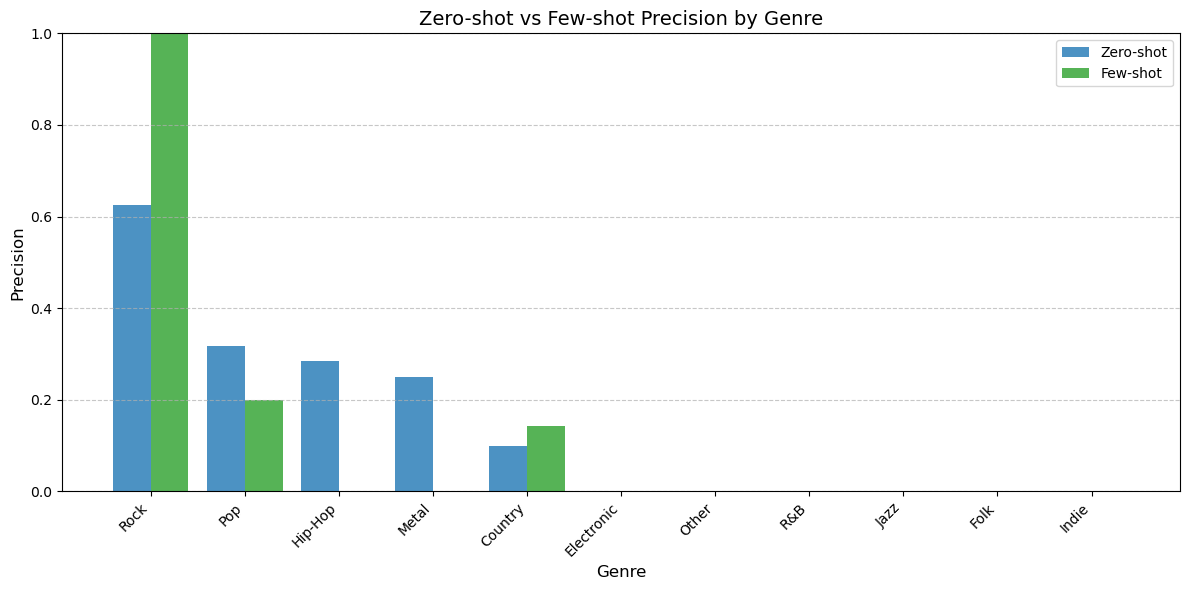

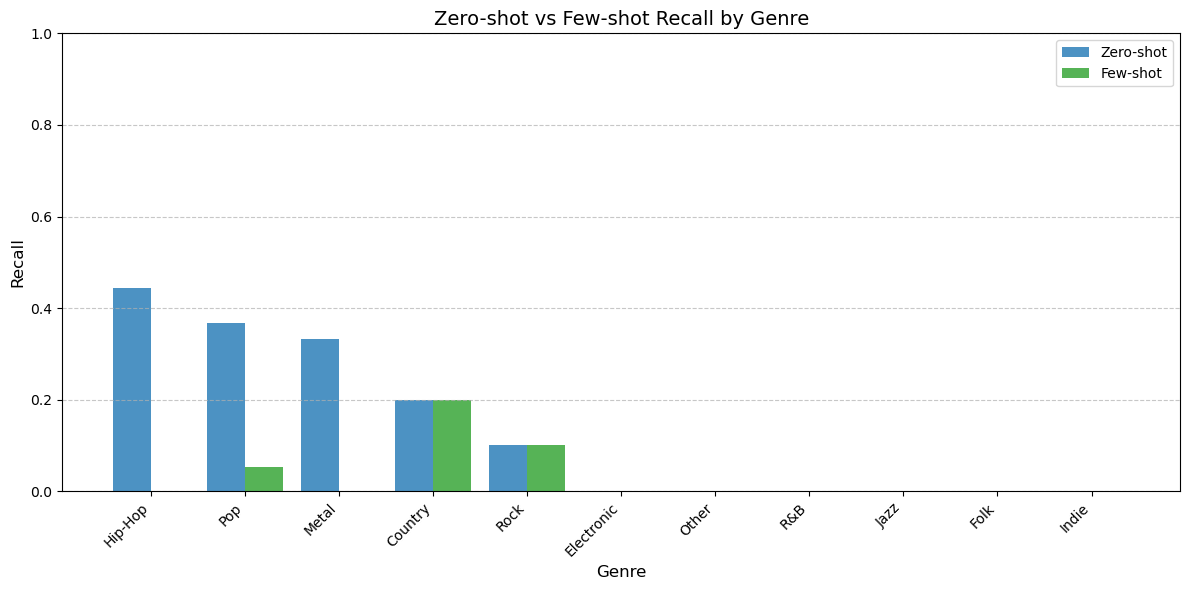

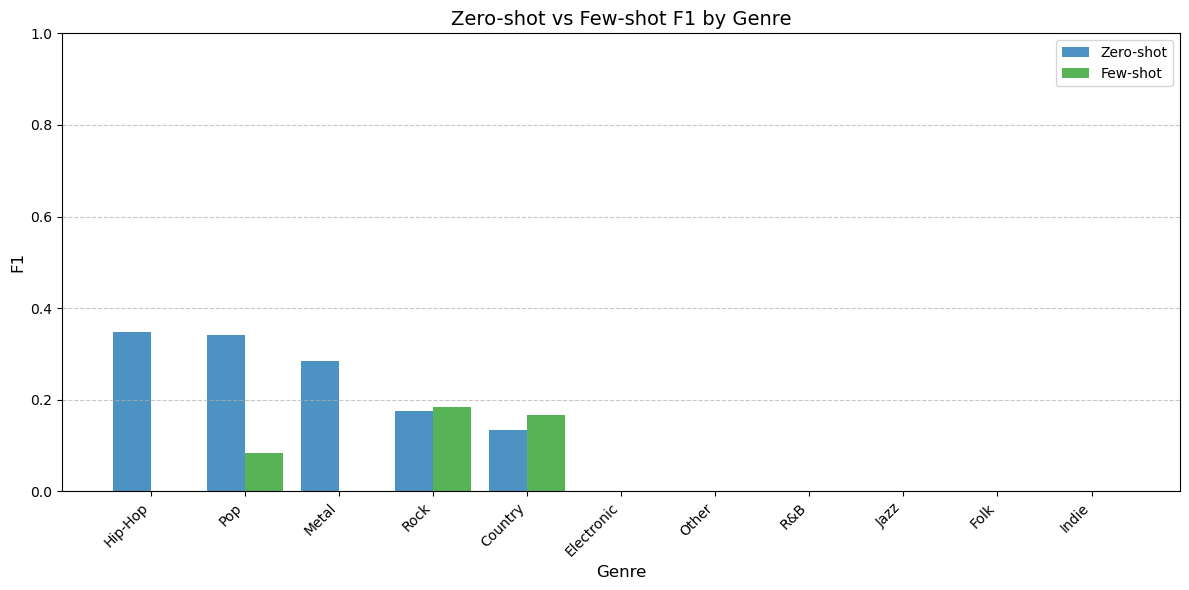

In [131]:
import matplotlib.pyplot as plt

def plot_metric_comparison(zero_results, few_results, metric_name):
    """
    Plots a comparison bar chart for a given metric (Precision, Recall, or F1)
    between Zero-shot and Few-shot results for each genre.
    
    Parameters:
    - zero_results: DataFrame containing Zero-shot results (generated by create_results_df)
    - few_results: DataFrame containing Few-shot results
    - metric_name: Name of the metric to plot ('Precision', 'Recall', or 'F1')
    """
    # Sort the genres based on the Zero-shot values for the selected metric (in descending order).
    sorted_genres = zero_results.loc[metric_name].sort_values(ascending=False).index.tolist()
    
    # Get the Zero-shot metric values for the sorted genres.
    zero_values = zero_results.loc[metric_name][sorted_genres]
    # Get the Few-shot metric values for the sorted genres.
    few_values = few_results.loc[metric_name][sorted_genres]

    # Set up the figure with a specified size.
    plt.figure(figsize=(12, 6))
    
    # Define the width of each bar.
    bar_width = 0.4
    # Create an array of positions on the x-axis for each genre.
    x = np.arange(len(sorted_genres))

    # Plot the Zero-shot metric values as a bar chart.
    # The bars are shifted left by half the bar width for alignment.
    plt.bar(x - bar_width/2, zero_values, width=bar_width, label='Zero-shot', color='#1f77b4', alpha=0.8)
    
    # Plot the Few-shot metric values as a bar chart.
    # The bars are shifted right by half the bar width for alignment.
    plt.bar(x + bar_width/2, few_values, width=bar_width, label='Few-shot', color='#2ca02c', alpha=0.8)

    # Set the x-axis label.
    plt.xlabel('Genre', fontsize=12)
    # Set the y-axis label to the metric name.
    plt.ylabel(metric_name, fontsize=12)
    # Set the title of the plot dynamically based on the metric.
    plt.title(f'Zero-shot vs Few-shot {metric_name} by Genre', fontsize=14)
    
    # Set the x-tick labels to be the genre names, rotated for better readability.
    plt.xticks(x, sorted_genres, rotation=45, ha='right')
    # Set the y-axis limit from 0 to 1 as the metric values range between these values.
    plt.ylim(0, 1.0)

    # Add a legend in the upper right corner.
    plt.legend(loc='upper right')
    # Add horizontal grid lines with a dashed style to improve readability.
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    # Adjust layout so that everything fits without overlapping.
    plt.tight_layout()
    # Display the plot.
    plt.show()

# Generate DataFrames for Zero-shot and Few-shot results.
df_zero = create_results_df(zero_shot_results)
df_few = create_results_df(few_shot_results)

# Loop through the list of metrics ('Precision', 'Recall', 'F1')
# and generate a bar chart for each metric.
for metric in ['Precision', 'Recall', 'F1']:
    plot_metric_comparison(df_zero, df_few, metric)


In [132]:
# Calculate and print overall performance using Macro Precision, Recall, and F1 Score

print("\nOverall Performance:")

# Evaluate the zero-shot prompting strategy

print("Zero-shot:")

# Calculate macro-averaged precision for zero-shot predictions.
# 'macro' average computes metrics for each genre and then takes the unweighted mean.
macro_precision_zero = precision_score(
    test_data['genre'],       # True labels for each test instance.
    zero_shot_predictions,    # Predicted genres using the zero-shot approach.
    average='macro',          # Calculate the unweighted average over all genres.
    zero_division=0            # Avoid division by zero by setting undefined scores to 0.
)

# Calculate macro-averaged recall for zero-shot predictions.
macro_recall_zero = recall_score(
    test_data['genre'],       # True genre labels.
    zero_shot_predictions,    # Predictions from the zero-shot method.
    average='macro',          # Use macro averaging across genres.
    zero_division=0            # Replace undefined recall with 0 when division by zero occurs.
)

# Calculate macro-averaged F1 score for zero-shot predictions.
macro_f1_zero = f1_score(
    test_data['genre'],       # Ground truth genre labels.
    zero_shot_predictions,    # Zero-shot predicted genres.
    average='macro',          # Macro-average: compute per genre and take the mean.
    zero_division=0            # Set F1 to 0 when there is division by zero.
)

# Print the computed macro precision, recall, and F1 score for zero-shot predictions.
print(f"Macro Precision: {macro_precision_zero:.3f}")
print(f"Macro Recall:    {macro_recall_zero:.3f}")
print(f"Macro F1:        {macro_f1_zero:.3f}")

# Evaluate the few-shot prompting strategy

print("\nFew-shot:")

# Calculate macro-averaged precision for few-shot predictions.
macro_precision_few = precision_score(
    test_data['genre'],       # True genre labels.
    few_shot_predictions,     # Predicted genres using the few-shot approach.
    average='macro',          # Calculate macro-average precision.
    zero_division=0            # Set undefined precision values to 0.
)

# Calculate macro-averaged recall for few-shot predictions.
macro_recall_few = recall_score(
    test_data['genre'],       # Ground truth genre labels.
    few_shot_predictions,     # Few-shot predicted genres.
    average='macro',          # Use macro averaging for recall.
    zero_division=0            # Handle division by zero by assigning 0.
)

# Calculate macro-averaged F1 score for few-shot predictions.
macro_f1_few = f1_score(
    test_data['genre'],       # True labels for each sample.
    few_shot_predictions,     # Predictions from the few-shot method.
    average='macro',          # Macro average over all genres.
    zero_division=0            # Avoid division by zero errors.
)

# Print the computed macro precision, recall, and F1 score for few-shot predictions.
print(f"Macro Precision: {macro_precision_few:.3f}")
print(f"Macro Recall:    {macro_recall_few:.3f}")
print(f"Macro F1:        {macro_f1_few:.3f}")

# Compare the overall Macro F1 scores of the two strategies to draw a conclusion
if macro_f1_zero > macro_f1_few:
    print("\nConclusion: Zero-shot strategy achieved higher overall Macro F1.")
else:
    print("\nConclusion: Few-shot strategy achieved higher overall Macro F1.")



Overall Performance:
Zero-shot:
Macro Precision: 0.099
Macro Recall:    0.091
Macro F1:        0.080

Few-shot:
Macro Precision: 0.031
Macro Recall:    0.008
Macro F1:        0.010

Conclusion: Zero-shot strategy achieved higher overall Macro F1.
